# Monthly Rain Reports - Version2


In [1]:
%load_ext autoreload
%autoreload 2

import logging
from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import contextily as cx

from mergedownloader.inpeparser import INPE_SERVER, InpeParsers, InpeTypes
from mergedownloader.downloader import Downloader
# from rainreporter.reporter import Reporter

import rasterio as rio
import xarray as xr


## Opening Basins of INterest

In [2]:
shapes_mac = Path('/Users/cordmaur/Library/CloudStorage/OneDrive-AgênciaNacionaldeÁguas/Trabalho/SOE/COVEC/Bases/bacias de interesse SOE')
shapes_container = Path('/workspaces/reports_folder/bases/bacias_interesse')

shapes = shapes_mac if shapes_mac.exists() else shapes_container
assert shapes.exists()

In [3]:
basins = {file.stem.split('_')[-1]: file for file in shapes.iterdir() if file.suffix == '.shp'}

In [4]:
basins

{'proj': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/Bacaia_Paranaiba_diss_proj.shp'),
 'ParaibaDoSul': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_ParaibaDoSul.shp'),
 'ANA': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacias_interesse_ANA.shp'),
 'Doce': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Doce.shp'),
 'wgs84': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Doce_wgs84.shp'),
 'Itapecuru': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Itapecuru.shp'),
 'Jequitinhonha': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Jequitinhonha.shp'),
 'Madeira': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Madeira.shp'),
 'PortoVelho': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Madeira_em_PortoVelho.shp'),
 'Negro': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Negro.shp'),
 'Paraguai': 

## Create a Reporter Instance

In [5]:
from rainreporter.reporter import Reporter
from rainreporter.monthly_report import MonthlyReport
from mergedownloader.file_downloader import FileDownloader, ConnectionType, DownloadMode


In [6]:
# Create a Downloader instance
fd = FileDownloader(
    server=INPE_SERVER, 
    connection_type=ConnectionType.HTTP,
    download_mode=DownloadMode.NO_UPDATE
)
downloader = Downloader(
    file_downloader=fd,
    local_folder='/workspaces/reports_folder/downloads2',
    parsers=InpeParsers
)

Using wget through HTTP on: ftp.cptec.inpe.br


In [7]:
reporter = Reporter(
    downloader=downloader,
    config_file='../reporter.json5',
    bases_folder='/workspaces/reports_folder/bases'
)

../data/cities/cidades.shp
../data/states/BR_UF_2022.shp
../data/rivers/main_rivers.shp
../data/dams


In [8]:
config = Reporter.open_config_file('/workspaces/reports_folder/configs/parana.json5')
config

{'arquivo': 'Relatorios_Gerais/Parana',
 'data': False,
 'relatorios': [{'nome': 'Parana',
   'tipo': 'Mensal',
   'shp': 'bacias_interesse/bacia_Parana.shp',
   'inicio_periodo_chuvoso': 10,
   'total_meses': 23}]}

In [9]:
attrs = config['relatorios'][0]
attrs

{'nome': 'Parana',
 'tipo': 'Mensal',
 'shp': 'bacias_interesse/bacia_Parana.shp',
 'inicio_periodo_chuvoso': 10,
 'total_meses': 23}

In [10]:
report = reporter.generate_report('2024-10', attrs)

/usr/local/lib/python3.10/dist-packages/ecmwflibs/__init__.py:81: UserWarning: libglib-2.0.so.0: cannot open shared object file: No such file or directory
  warnings.warn(str(e))
Ignoring index file '/workspaces/reports_folder/downloads2/DAILY/2024/09/MERGE_CPTEC_20240923.grib2.923a8.idx' older than GRIB file


In [11]:
%matplotlib inline

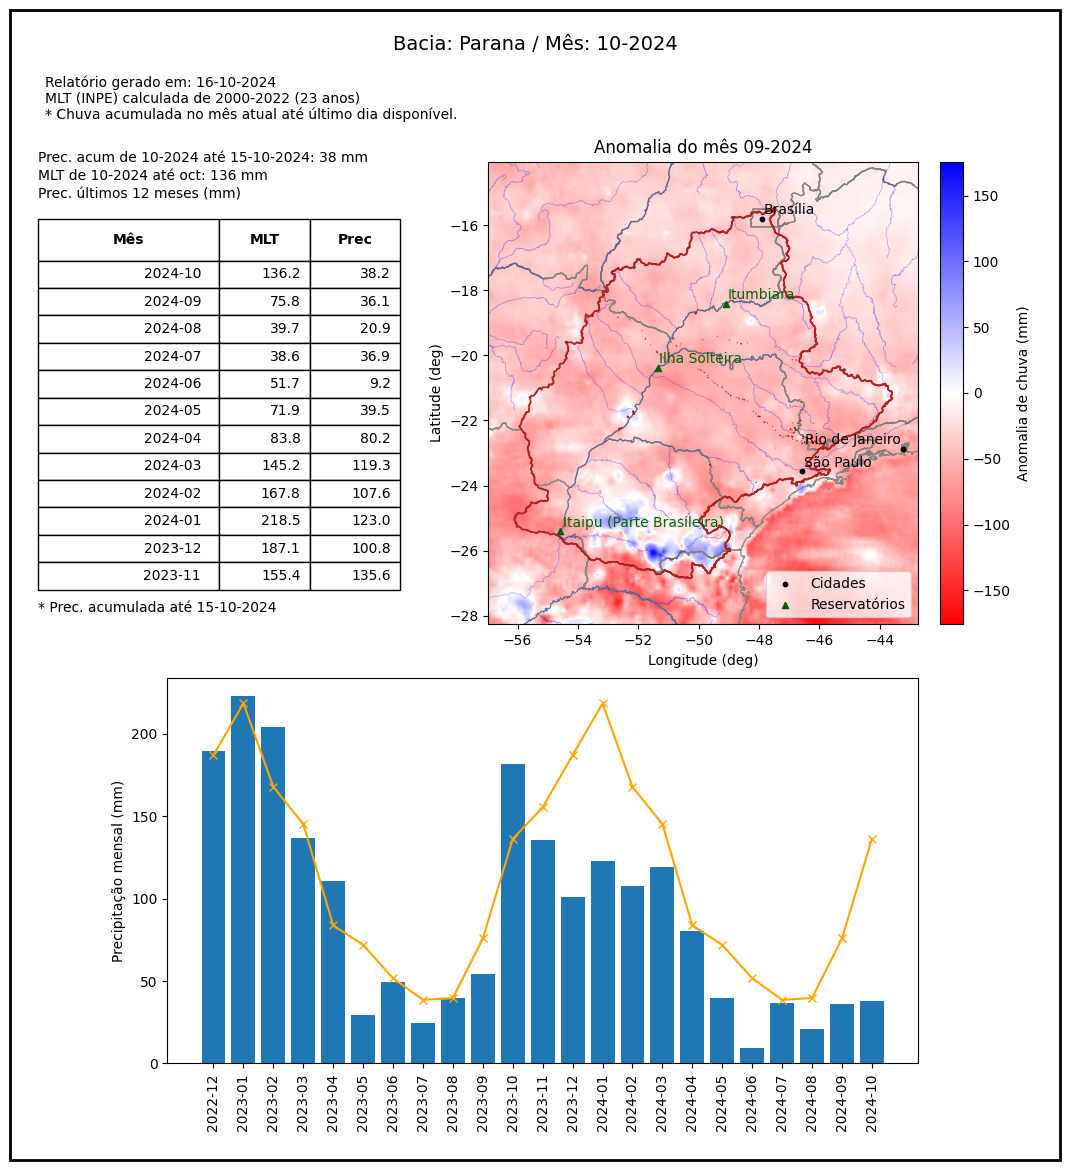

In [13]:
report[0]

## Generate ReportCollection (PDF)

In [34]:
reporter.generate_pdf(
    json_file='../configs/pbs2.json5',
    output_folder='/workspaces/reports_folder/tmp',
)

## Export data to PowerBI

In [41]:
import geopandas as gpd

In [86]:
reporter.export_report_data(
    date_str='2024-10',
    attrs=config['relatorios'][0],
    output_db='/workspaces/reports_folder/tmp/rcar_monthly_rain.parquet',
    assets_folder='/workspaces/reports_folder/tmp/assets',
)

In [94]:
# export another basin
config = Reporter.open_config_file('../configs/sao_francisco_simples.json5')

reporter.export_report_data(
    date_str='2024-10',
    attrs=config['relatorios'][0],
    output_db='/workspaces/reports_folder/tmp/rcar_monthly_rain.parquet',
    assets_folder='/workspaces/reports_folder/tmp/assets',
)

In [92]:
config['relatorios'][0]

{'nome': 'São Francisco',
 'tipo': 'Mensal',
 'shp': 'bacias_interesse/bacia_Sao_Francisco.shp',
 'inicio_periodo_chuvoso': 10,
 'total_meses': 23}

In [95]:
df = pd.read_parquet(
    '/workspaces/reports_folder/tmp/rcar_monthly_rain.parquet', 
)
df

time       pacum         lta  last_date  \
month   basin                                                                   
2022-11 Paraiba do Sul 2022-11-01 12:00:00  178.653336  189.197816        NaT   
        São Francisco  2022-11-01 12:00:00  211.573914  132.075899        NaT   
2022-12 Paraiba do Sul 2022-12-01 12:00:00  215.332062  228.355395        NaT   
        São Francisco  2022-12-01 12:00:00  198.962265  153.943072        NaT   
2023-01 Paraiba do Sul 2023-01-01 12:00:00  237.794464  225.280874        NaT   
        São Francisco  2023-01-01 12:00:00  137.574783  140.987102        NaT   
2023-02 Paraiba do Sul 2023-02-01 12:00:00  163.262711  156.675482        NaT   
        São Francisco  2023-02-01 12:00:00   35.457886  111.836557        NaT   
2023-03 Paraiba do Sul 2023-03-01 12:00:00   81.767151  156.036149        NaT   
        São Francisco  2023-03-01 12:00:00   72.170418  120.647628        NaT   
2023-04 Paraiba do Sul 2023-04-01 12:00:00   89.193092   74.529571        NaT   
        São Francisco  2023-04-01 12:00:00   44.668278   61.965822        NaT   
2023-05 Paraiba do Sul 2023-05-01 12:00:00   16.219131   45.205898        NaT   
        São Francisco  2023-05-01 12:00:00   20.358580   25.628210        NaT   
2023-06 Paraiba do Sul 2023-06-01 12:00:00   13.084985   26.515678        NaT   
        São Francisco  2023-06-01 12:00:00   12.578908   12.649975        NaT   
2023-07 Paraiba do Sul 2023-07-01 12:00:00   14.262958   24.970317        NaT   
        São Francisco  2023-07-01 12:00:00    5.712335   10.093279        NaT   
2023-08 Paraiba do Sul 2023-08-01 12:00:00   50.669460   29.175898        NaT   
        São Francisco  2023-08-01 12:00:00   13.090914    8.598948        NaT   
2023-09 Paraiba do Sul 2023-09-01 12:00:00   27.654980   55.052486        NaT   
        São Francisco  2023-09-01 12:00:00    9.634840   15.221847        NaT   
2023-10 Paraiba do Sul 2023-10-01 12:00:00  161.747971  106.831063        NaT   
        São Francisco  2023-10-01 12:00:00   36.224976   52.759258        NaT   
2023-11 Paraiba do Sul 2023-11-01 12:00:00   98.932419  189.197816        NaT   
        São Francisco  2023-11-01 12:00:00   62.974884  132.075899        NaT   
2023-12 Paraiba do Sul 2023-12-01 12:00:00  109.127411  228.355395        NaT   
        São Francisco  2023-12-01 12:00:00   68.675827  153.943072        NaT   
2024-01 Paraiba do Sul 2024-01-01 12:00:00  210.781891  225.280874        NaT   
        São Francisco  2024-01-01 12:00:00  202.756866  140.987102        NaT   
2024-02 Paraiba do Sul 2024-02-01 12:00:00  147.784805  156.675482        NaT   
        São Francisco  2024-02-01 12:00:00  159.169922  111.836557        NaT   
2024-03 Paraiba do Sul 2024-03-01 12:00:00  164.784805  156.036149        NaT   
        São Francisco  2024-03-01 12:00:00   79.999306  120.647628        NaT   
2024-04 Paraiba do Sul 2024-04-01 12:00:00   14.115853   74.529571        NaT   
        São Francisco  2024-04-01 12:00:00   71.875237   61.965822        NaT   
2024-05 Paraiba do Sul 2024-05-01 12:00:00   22.099339   45.205898        NaT   
        São Francisco  2024-05-01 12:00:00   11.237782   25.628210        NaT   
2024-06 Paraiba do Sul 2024-06-01 12:00:00    2.222561   26.515678        NaT   
        São Francisco  2024-06-01 12:00:00    8.824753   12.649975        NaT   
2024-07 Paraiba do Sul 2024-07-01 12:00:00   12.283029   24.970317        NaT   
        São Francisco  2024-07-01 12:00:00    6.177036   10.093279        NaT   
2024-08 Paraiba do Sul 2024-08-01 12:00:00   28.455284   29.175898        NaT   
        São Francisco  2024-08-01 12:00:00    2.285264    8.598948        NaT   
2024-09 Paraiba do Sul 2024-09-01 12:00:00   10.796875   55.052486        NaT   
        São Francisco  2024-09-01 12:00:00    1.606968   15.221847        NaT   
2024-10 Paraiba do Sul 2024-10-01 12:00:00    3.765752  106.831063 2024-10-09   
        São Francisco  2024-10-01 12:00:00    0.746492   52.759258 20

In [38]:
template = Reporter.templates['Mensal']

In [40]:
monthly = template.from_dict(downloader=reporter.downloader, mapper=reporter.mapper, config=attrs, bases_folder=reporter.bases_folder)

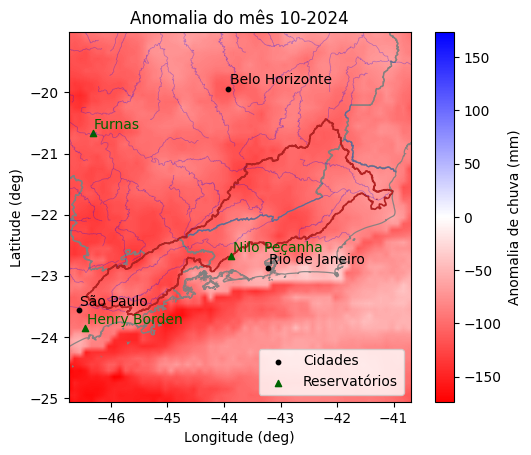

In [43]:
fig, ax = plt.subplots()
monthly.plot_anomaly_map(
    date='2024-10',
    shp=gpd.read_file(attrs['shp']),
    plt_ax=ax,
)

In [73]:
df = monthly._create_rain_lta_df('2024-10')

In [75]:
frame.combine_first(df)

,anomaly_map,basin,last_date,lta,pacum,time
month,,,,,,
2022-11,NaN,Paraiba do Sul,NaT,189.197816,178.653336,2022-11-01 12:00:00
2022-12,NaN,Paraiba do Sul,NaT,228.355395,215.332062,2022-12-01 12:00:00
2023-01,NaN,Paraiba do Sul,NaT,225.280874,237.794464,2023-01-01 12:00:00
2023-02,NaN,Paraiba do Sul,NaT,156.675482,163.262711,2023-02-01 12:00:00
2023-03,NaN,Paraiba do Sul,NaT,156.036149,81.767151,2023-03-01 12:00:00
2023-04,NaN,Paraiba do Sul,NaT,74.529571,89.193092,2023-04-01 12:00:00
2023-05,NaN,Paraiba do Sul,NaT,45.205898,16.219131,2023-05-01 12:00:00
2023-06,NaN,Paraiba do Sul,NaT,26.515678,13.084985,2023-06-01 12:00:00
2023-07,NaN,Paraiba do Sul,NaT,24.970317,14.262958,2023-07-01 12:00:00


In [72]:
frame

,time,pacum,lta,basin,last_date,anomaly_map
month,,,,,,
2022-11,2022-11-01 12:00:00,178.653336,189.197816,Paraiba do Sul,None,NaN
2022-12,2022-12-01 12:00:00,215.332062,228.355395,Paraiba do Sul,None,NaN
2023-01,2023-01-01 12:00:00,237.794464,225.280874,Paraiba do Sul,None,NaN
2023-02,2023-02-01 12:00:00,163.262711,156.675482,Paraiba do Sul,None,NaN
2023-03,2023-03-01 12:00:00,81.767151,156.036149,Paraiba do Sul,None,NaN
2023-04,2023-04-01 12:00:00,89.193092,74.529571,Paraiba do Sul,None,NaN
2023-05,2023-05-01 12:00:00,16.219131,45.205898,Paraiba do Sul,None,NaN
2023-06,2023-06-01 12:00:00,13.084985,26.515678,Paraiba do Sul,None,NaN
2023-07,2023-07-01 12:00:00,14.262958,24.970317,Paraiba do Sul,None,NaN


## Create an ad-hoc report

In [5]:
from rainreporter.abstract_report import AbstractReport
from rainreporter.monthly_report import MonthlyReport
from rainreporter.utils import open_json_file
from rainreporter.mapper import Mapper

from mergedownloader.file_downloader import FileDownloader, ConnectionType, DownloadMode

In [6]:
# Create a Downloader instance
fd = FileDownloader(
    server=INPE_SERVER, 
    connection_type=ConnectionType.HTTP,
    download_mode=DownloadMode.NO_UPDATE
)
downloader = Downloader(
    file_downloader=fd,
    local_folder='/workspaces/reports_folder/downloads2',
    parsers=InpeParsers
)

Using wget through HTTP on: ftp.cptec.inpe.br


In [199]:
# Get the Shape of INterest
shp = basins['Uruguai']

In [194]:
# Create a Mapper instance
config = open_json_file('../reporter.json5')
mapper = Mapper(
    config=config['shape_style'],
    shapes=config['context_shapes']
)

../data/cities/cidades.shp
../data/states/BR_UF_2022.shp
../data/rivers/main_rivers.shp
../data/dams


In [200]:
# Create the Report instance
reporter = MonthlyReport(
    downloader=downloader,
    mapper=mapper,
    shp_file=shp,
    name='Uruguai',
    month_lbk=23,
    wet_month=10,
)

In [201]:
file = Path('/workspaces/reports_folder/tmp/rcar_data.csv')
assert file.exists()


In [203]:
reporter.export_report_data('2024-06', file)

In [207]:
report = reporter.generate_report(date_str='2024-10')

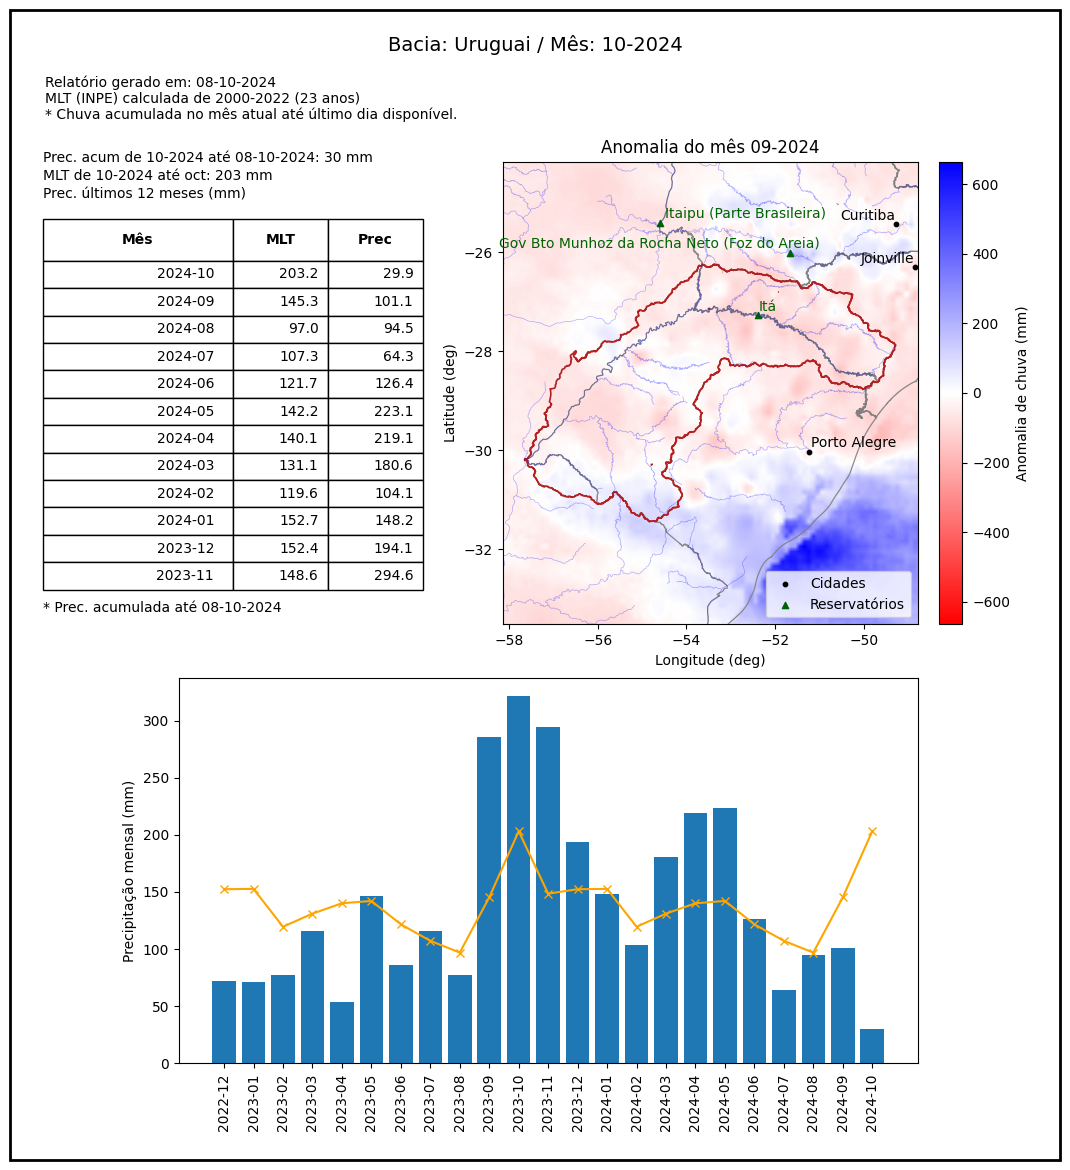

In [208]:
report[0]

In [209]:
report[2]

,time,pacum,lta,basin,last_date
month,,,,,
2022-12,2022-12-01 12:00:00,71.792572,152.435239,Uruguai,None
2023-01,2023-01-01 12:00:00,71.528534,152.726562,Uruguai,None
2023-02,2023-02-01 12:00:00,76.997223,119.607668,Uruguai,None
2023-03,2023-03-01 12:00:00,116.064720,131.081133,Uruguai,None
2023-04,2023-04-01 12:00:00,53.667637,140.137256,Uruguai,None
2023-05,2023-05-01 12:00:00,146.257217,142.184908,Uruguai,None
2023-06,2023-06-01 12:00:00,85.938828,121.714507,Uruguai,None
2023-07,2023-07-01 12:00:00,116.065811,107.299897,Uruguai,None
2023-08,2023-08-01 12:00:00,77.393471,97.003007,Uruguai,None


In [210]:
fig, ax = plt.subplots()
reporter.plot_anomaly_map(
    date='2024-09',
    shp=gdf,
    plt_ax=ax,
)

# Process Hot Folder

In [3]:
reporter = Reporter(
    server=INPEParsers.FTPurl, 
    download_folder='/workspaces/reports_folder/downloads', 
    log_level=logging.DEBUG,
    bases_folder='/workspaces/reports_folder/bases/',
    config_file='../reporter.json5'

    # parsers=INPEParsers.parsers,
    # post_processors=INPEParsers.post_processors
)


../data/cities/cidades.shp
../data/states/BR_UF_2022.shp
../data/rivers/main_rivers.shp
../data/dams


In [ ]:

reporter.process_folder(
    input_folder='/workspaces/reports_folder/hot_folder/',
    output_folder='/workspaces/reports_folder/output/',
    hot=False
)

# Process Entire Folder

In [35]:
reporter = Reporter(
    server=INPEParsers.FTPurl, 
    download_folder='/workspaces/reports_folder/downloads', 
    log_level=logging.INFO,
    bases_folder='/workspaces/reports_folder/bases/',
    config_file='../reporter.json5'
    # parsers=INPEParsers.parsers,
    # post_processors=INPEParsers.post_processors
)

../data/cities/cidades.shp
../data/states/BR_UF_2022.shp
../data/rivers/main_rivers.shp
../data/dams


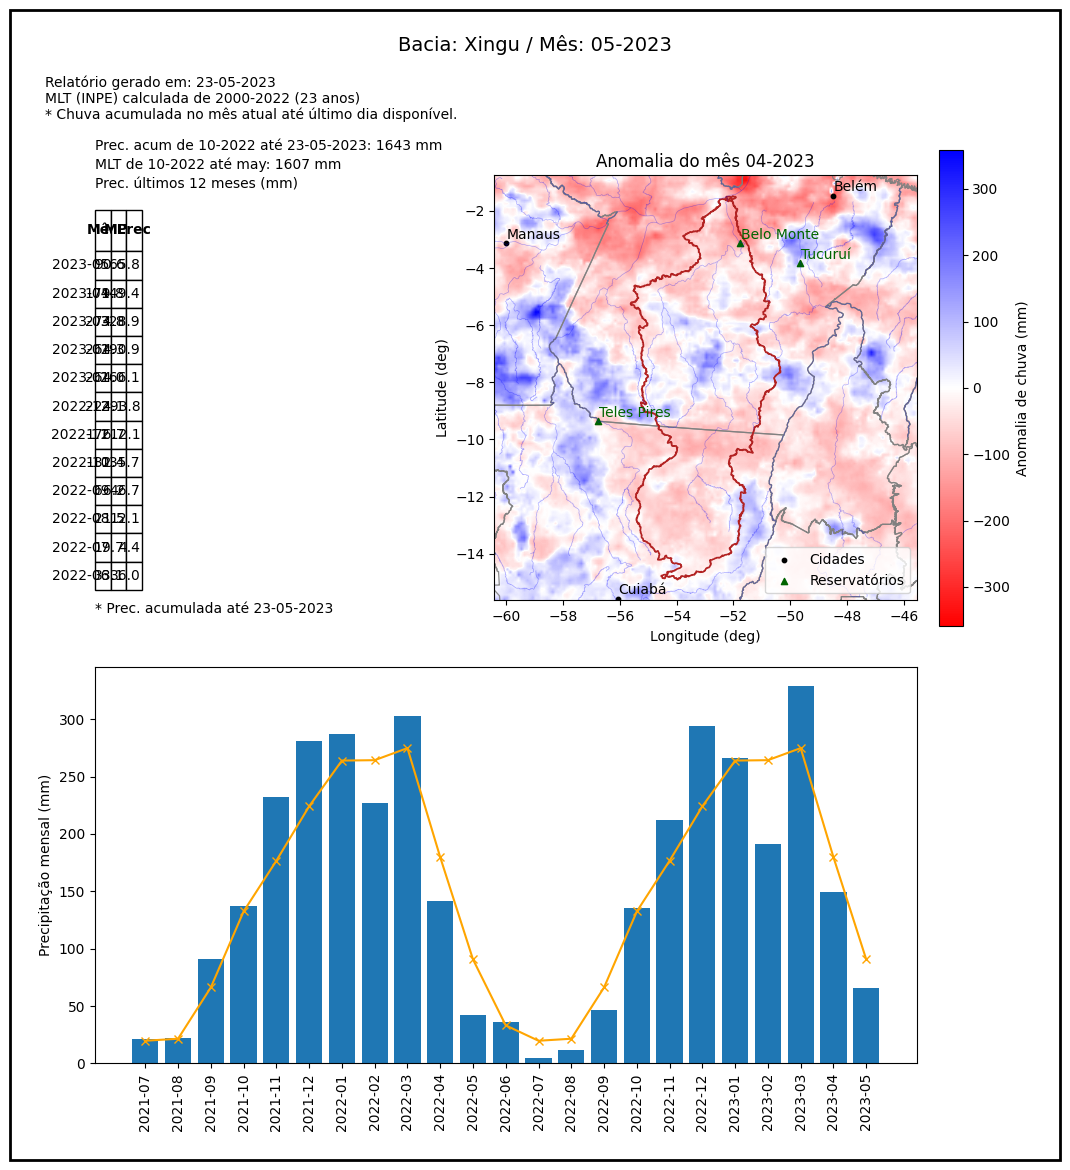

In [36]:
reporter.process_folder(
    input_folder='/workspaces/reports_folder/configs/',
    output_folder='/workspaces/reports_folder/output/'
)

In [3]:
shapes_container = Path('/workspaces/reports_folder/bases/BaciasIncrementais')
shapes_container.exists()


True

In [4]:
sf = shapes_container/'SaoFrancisco'

In [7]:
tres_marias = gpd.read_file(sf/'Incre_3_Marias_diss_proj.shp')

In [13]:
tres_marias

,Id,Nome,Area_km²,geometry
0,0,UHE Três Marias,57545.578138,"POLYGON ((-5052729.760 -2054701.559, -5052723...."


<Axes: >

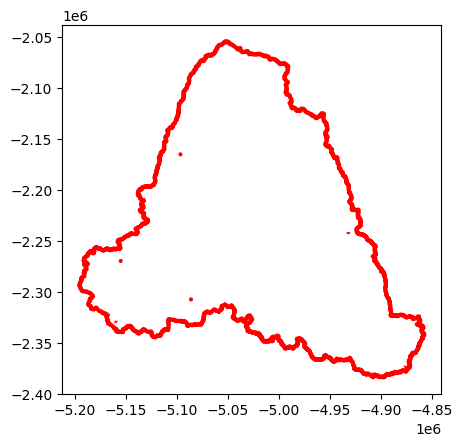

In [10]:
tres_marias.plot(facecolor='none', edgecolor= 'red', linewidth=3)

<Axes: >

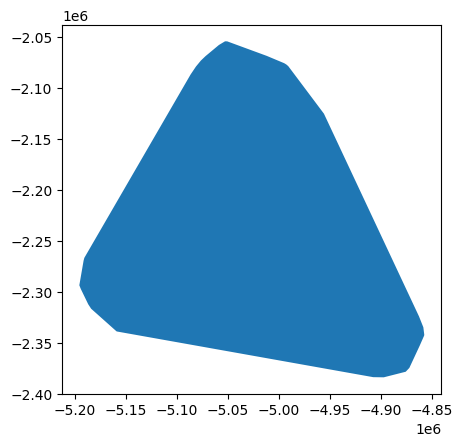

In [14]:
tres_marias.convex_hull.plot()

<Axes: >

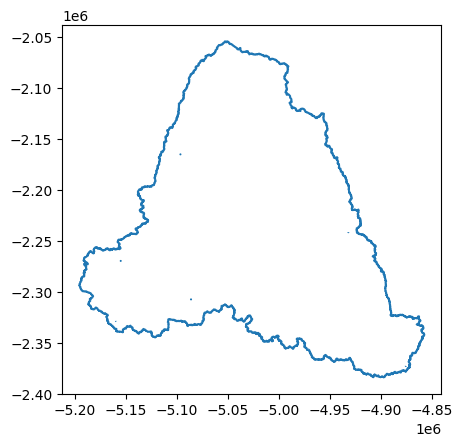

In [12]:
tres_marias.boundary.plot()